# Tutorial 5: Spatial domain guided 3D slices alignment
This tutorial demonstrates STAligner's ablility to align the spot coordinates of adjacent slices and build stacked 3D tissue with aligned coordinates. 

Here, we use the mouse hippocampus slices generated by Slide-seqV1. The original data can be downloaded from https://singlecell.broadinstitute.org/single_cell/study/SCP354/slide-seq-study. Processed h5ad files can be downloaded from https://drive.google.com/file/d/1xtOBHgx2JNcgTp5q-hSFVAZsdC6ic05S/view?usp=sharing

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import ST_utils
# import train_STAligner
import STAligner

# the location of R (used for the mclust clustering)
import os
os.environ['R_HOME'] = "/home/xzhou/anaconda3/envs/PyG/lib/R"
os.environ['R_USER'] = "/home/xzhou/anaconda3/envs/PyG/lib/python3.8/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg
from scipy.sparse import csr_matrix

import torch
used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## Load Data

In [3]:
Batch_list = []
adj_list = []
section_ids = ['Puck_180531_13', 'Puck_180531_16', 'Puck_180531_17', 'Puck_180531_18',
               'Puck_180531_19', 'Puck_180531_22', 'Puck_180531_23']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    adata = sc.read_h5ad("Data/"+section_id+".h5ad")
    adata.X = csr_matrix(adata.X)
    adata.var_names_make_unique(join="++")

    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]    
    
    # Constructing the spatial network
    STAligner.Cal_Spatial_Net(adata, rad_cutoff=50) # the spatial network are saved in adata.uns[‘adj’]
    # ST_utils.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
       
    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=10000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    adata = adata[:, adata.var['highly_variable']]
    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)


['Puck_180531_13', 'Puck_180531_16', 'Puck_180531_17', 'Puck_180531_18', 'Puck_180531_19', 'Puck_180531_22', 'Puck_180531_23']
Puck_180531_13
------Calculating spatial graph...
The graph contains 433158 edges, 32895 cells.
13.1679 neighbors per cell on average.
Puck_180531_16
------Calculating spatial graph...
The graph contains 201052 edges, 18631 cells.
10.7913 neighbors per cell on average.
Puck_180531_17
------Calculating spatial graph...
The graph contains 148656 edges, 14860 cells.
10.0038 neighbors per cell on average.
Puck_180531_18
------Calculating spatial graph...
The graph contains 335572 edges, 26912 cells.
12.4692 neighbors per cell on average.
Puck_180531_19
------Calculating spatial graph...
The graph contains 397714 edges, 31163 cells.
12.7624 neighbors per cell on average.
Puck_180531_22
------Calculating spatial graph...
The graph contains 368762 edges, 28676 cells.
12.8596 neighbors per cell on average.
Puck_180531_23
------Calculating spatial graph...
The graph con

## Concat the scanpy objects for multiple slices

In [4]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (171645, 1032)


## Running STAligner

In [5]:
%%time
# iter_comb is used to specify the order of integration. For example, (0, 1) means slice 0 will be algined with slice 1 as reference.
iter_comb = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]

# Here, to reduce GPU memory usage, each slice is considered as a subgraph for training.
adata_concat = STAligner.train_STAligner_subgraph(adata_concat, verbose=True, knn_neigh = 100, n_epochs = 600, iter_comb = iter_comb, 
                                                        Batch_list=Batch_list, device=used_device)

STAligner(
  (conv1): GATConv(1032, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 1032, heads=1)
)
Pretrain with STAGATE...


100%|██████████| 500/500 [02:12<00:00,  3.76it/s]


Train with STAligner...


  0%|          | 0/100 [00:00<?, ?it/s]

Update spot triplets at epoch 500


100%|██████████| 100/100 [01:51<00:00,  1.11s/it]

CPU times: user 5min 35s, sys: 6.43 s, total: 5min 42s
Wall time: 4min 8s


## Clustering

In [6]:
sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.louvain(adata_concat, random_state=666, key_added="louvain", resolution=0.2)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Visualization

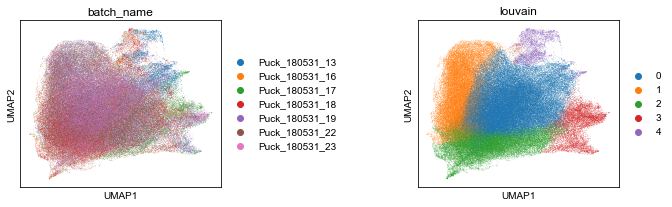

In [7]:
sc.tl.umap(adata_concat, random_state=666)

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 10

sc.pl.umap(adata_concat, color=['batch_name', 'louvain'], ncols=2, wspace=0.8, show=True)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


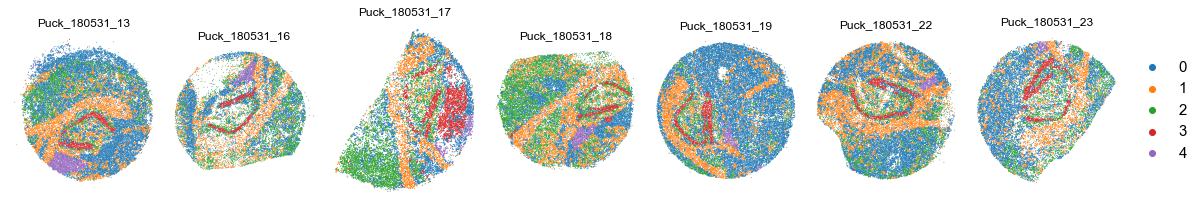

In [8]:
for it in range(len(section_ids)):
    Batch_list[it].obs['louvain'] = adata_concat[adata_concat.obs['batch_name'] == section_ids[it]].obs['louvain'].values

spot_size = 30
title_size = 15
fig, ax = plt.subplots(1, 7, figsize=(20, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for it in range(len(section_ids)):
    if it == 6:
        _sc_0= sc.pl.spatial(Batch_list[it], img_key=None, color=['louvain'], title=[section_ids[it]],
                              legend_fontsize=15, show=False, ax=ax[it], frameon=False, spot_size=spot_size)        
    else:
        _sc_0 = sc.pl.spatial(Batch_list[it], img_key=None, color=['louvain'], title=[section_ids[it]],
                              legend_loc=None, show=False, ax=ax[it], frameon=False, spot_size=spot_size)

plt.show()

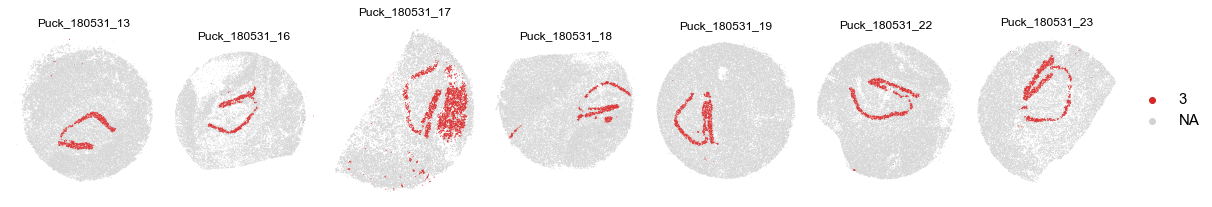

In [9]:
# Here, we use domain 3 as landmark domain, which has a clear "cord-arrow-like" structure.
landmark_domain = '3'
fig, ax = plt.subplots(1, 7, figsize=(20, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for it in range(len(section_ids)):
    if it == 6:
        _sc_0= sc.pl.spatial(Batch_list[it], img_key=None, color=['louvain'], title=[section_ids[it]],
                              legend_fontsize=15, show=False, ax=ax[it], frameon=False, spot_size=spot_size, groups=[landmark_domain])        
    else:
        _sc_0 = sc.pl.spatial(Batch_list[it], img_key=None, color=['louvain'], title=[section_ids[it]],
                              legend_loc=None, show=False, ax=ax[it], frameon=False, spot_size=spot_size, groups=[landmark_domain])

plt.show()

In [10]:
for it in range(len(section_ids)):
    Batch_list[it].obs['louvain'] = adata_concat[adata_concat.obs['batch_name'] == section_ids[it]].obs['louvain'].values

## Spatial domain guided 3D slices alignment
The MNNs in the landmark domain are selected as anchor pairs to guide the alignment process in ICP algorithm.

In [11]:
iter_comb = [(0,6), (1,6), (2,6), (3,6), (4,6), (5,6)]
landmark_domain = ['3']
for comb in iter_comb:
    print(comb)
    i, j = comb[0], comb[1]
    adata_target = Batch_list[i]
    adata_ref = Batch_list[j]
    slice_target = section_ids[i]
    slice_ref = section_ids[j]
    
    aligned_coor = STAligner.ICP_align(adata_concat, adata_target, adata_ref, slice_target, slice_ref, landmark_domain)
    adata_target.obsm["spatial"] = aligned_coor

(0, 6)
(1, 6)
(2, 6)
(3, 6)
(4, 6)
(5, 6)


## After coordinates alignment

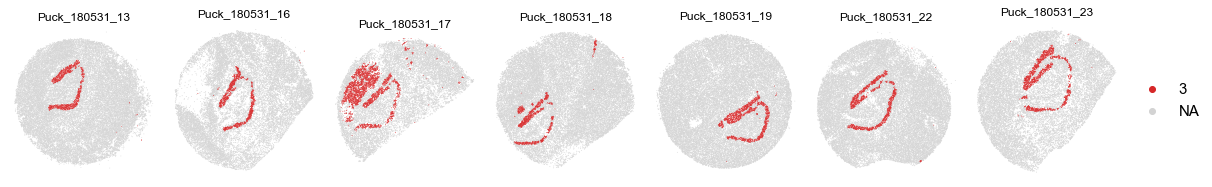

In [12]:
landmark_domain = '3'
fig, ax = plt.subplots(1, 7, figsize=(20, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for it in range(len(section_ids)):
    if it == 6:
        _sc_0= sc.pl.spatial(Batch_list[it], img_key=None, color=['louvain'], title=[section_ids[it]],
                              legend_fontsize=15, show=False, ax=ax[it], frameon=False, spot_size=spot_size, groups=[landmark_domain])        
    else:
        _sc_0 = sc.pl.spatial(Batch_list[it], img_key=None, color=['louvain'], title=[section_ids[it]],
                              legend_loc=None, show=False, ax=ax[it], frameon=False, spot_size=spot_size, groups=[landmark_domain])

plt.show()

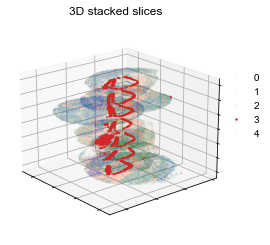

In [13]:
adata_concat.obs['Z'] = list(Batch_list[0].shape[0] * [0]) + list(Batch_list[1].shape[0] * [10]) \
+ list(Batch_list[2].shape[0] * [20]) + list(Batch_list[3].shape[0] * [30])\
+ list(Batch_list[4].shape[0] * [40]) + list(Batch_list[5].shape[0] * [50]) + list(Batch_list[6].shape[0] * [60])

All_coor = adata_concat.obs[['X', 'Y', 'Z']].copy()
All_coor.loc[adata_concat.obs['batch_name'] == section_ids[0], :2] = Batch_list[0].obsm["spatial"]
All_coor.loc[adata_concat.obs['batch_name'] == section_ids[1], :2] = Batch_list[1].obsm["spatial"]
All_coor.loc[adata_concat.obs['batch_name'] == section_ids[2], :2] = Batch_list[2].obsm["spatial"]
All_coor.loc[adata_concat.obs['batch_name'] == section_ids[3], :2] = Batch_list[3].obsm["spatial"]
All_coor.loc[adata_concat.obs['batch_name'] == section_ids[4], :2] = Batch_list[4].obsm["spatial"]
All_coor.loc[adata_concat.obs['batch_name'] == section_ids[5], :2] = Batch_list[5].obsm["spatial"]
All_coor.loc[adata_concat.obs['batch_name'] == section_ids[6], :2] = Batch_list[6].obsm["spatial"]

landmark_domain = '3'

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 4))
ax1 = plt.axes(projection='3d')

for it, label in enumerate(np.unique(adata_concat.obs['louvain'])):
    temp_Coor = All_coor.loc[adata_concat.obs['louvain'] == label, :]
    temp_xd = temp_Coor['X']
    temp_yd = temp_Coor['Y']
    temp_zd = temp_Coor['Z']
    if label == landmark_domain:
        ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=adata_concat.uns['louvain_colors'][it],
                      s=0.02, marker="o", label=label, alpha=1)
    else:
        ax1.scatter3D(temp_xd, temp_yd, temp_zd, c=adata_concat.uns['louvain_colors'][it],
                      s=0.02, marker="o", label=label, alpha=0.05)        
    
plt.legend(bbox_to_anchor=(1.2, 0.8), markerscale=10, frameon=False)
plt.title('3D stacked slices')
ax1.elev = 20
ax1.azim = -40

ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])   

plt.show()